# 1. Import libraries, helper functions and datapaths

### 1.1 Importing Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchinfo import summary

In [2]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from typing import List, Tuple, Dict
from tqdm.auto import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Import helper functions

In [5]:
from going_modular.engine import train_step
from going_modular.data_setup import create_dataloaders

In [6]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = torch.device)->Tuple[float,float]:

    #putting model on evaluation mode
    model.eval()

    #Setup test loss and test accuracy values
    val_loss, val_acc = 0,0

    #turning on inference mode (we don't need the gradient engine activated)
    with torch.inference_mode():
        #Loop through Dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            #1. Forward pass
            val_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(val_pred_logits,y)
            val_loss += loss.item()

            #Calculate the accuracy
            val_pred_labels = torch.argmax(val_pred_logits, axis = 1)
            val_acc += (val_pred_labels==y).sum().item()/len(val_pred_labels)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)

    return val_loss, val_acc

In [7]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    '''
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance trancking to a specific directory
    '''
    from datetime import datetime
    import os

    #get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name,extra)
    else:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name)

    print(f"Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir)

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(model: torch.nn.Module,
         train_dataloader,
         val_dataloader,
         optimizer,
         writer: torch.utils.tensorboard.writer.SummaryWriter,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
         epochs: int = 5,
         device = torch.device,
         lr_scheduler = None)->Dict[str,List]:

    #Create dictionary of lists
    results = {"train_loss": [],
              "train_acc": [],
              "val_loss": [],
              "val_acc": []}

    #looping through training and test steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer,
                                          device = device)

        val_loss, val_acc = val_step(model = model,
                                       dataloader = val_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)
        current_lr = optimizer.param_groups[0]['lr']

        #print out what's happening
        print(f'''Epoch: {epoch+1}| Train loss: {train_loss:.4f} and Train acuuracry: {train_acc:.4f} |
                  Validation loss: {val_loss:.4f} and Validation accuracy: {val_acc:.4f}|
                  LR: {current_lr}''')


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        ###Alteration (NEW): Experiment Tracking###
        if writer:
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict = {"train_loss":train_loss,
                                                "val_loss":val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag = "Accuracy",
                             tag_scalar_dict = {"train_acc":train_acc,
                                               "val_acc":val_acc},
                             global_step = epoch)
            if epoch == 0:
                writer.add_graph(model = model,
                                input_to_model = torch.randn(32,3,224,224).to(device))
        else:
            pass

        #stepping the lr_scheduler
        if lr_scheduler is not None:
            lr_scheduler.step()
    #Close the writer
    writer.close()

    return results

In [9]:
def save_model(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None,
               epoch: int = 0,
               initial_training_completed: bool = False,
               target_dir: str = "models",
               model_name: str = "model_checkpoint.pth"):
    """
    Saves a dictionary containing model, optimizer, scheduler states, and training metadata.

    Args:
        model: The PyTorch model to save.
        optimizer: The optimizer used during training.
        scheduler: The learning rate scheduler used during training (optional).
        epoch: The current epoch number.
        initial_training_completed: Flag indicating if initial training phase is complete.
        target_dir: Directory where the checkpoint will be saved.
        model_name: Filename for the checkpoint, should end with '.pth' or '.pt'.

    Example usage:
        save_model(model=model_0,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   epoch=15,
                   initial_training_completed=True,
                   target_dir="models",
                   model_name="efficientnet_b0_initial_training.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), \
        "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'initial_training_completed': initial_training_completed,
    }

    print(f"[INFO] Saving checkpoint to: {model_save_path}")
    torch.save(obj=checkpoint, f=model_save_path)

In [10]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]], title=None):
    '''
    Plots training curves of a results dictionary with unique markers and grid lines.
    '''
    # Get the loss and accuracy values
    loss = results["train_loss"]
    test_loss = results["val_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["val_acc"] 
    
    # Number of epochs
    epochs = range(len(loss))
    
    # Setup plot
    plt.figure(figsize=(15, 7))
    
    # Plot the loss with unique markers
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss', marker='o', linestyle='-')
    plt.plot(epochs, test_loss, label='Val Loss', marker='D', linestyle='--')
    plt.title('Loss' if title is None else f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot the accuracy with unique markers
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy", marker='*', linestyle='-')
    plt.plot(epochs, test_accuracy, label="Val Accuracy", marker='^', linestyle='--')
    plt.title("Accuracy" if title is None else f'{title} - Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List
import numpy as np

def plot_confusion_matrix(model: torch.nn.Module,
                          dataloader: torch.utils.data.DataLoader,
                          class_names: List[str],
                          device=torch.device("cpu")):
    """
    Computes and plots the confusion matrix for a given model and dataloader.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test dataset.
        class_names: List of class names in the same order as in ImageFolder.
        device: Device on which computation should happen (default: "cpu").
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc


def plot_multiclass_roc_curve(model, dataloader, class_names, device, title=None):
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Softmax for multiclass
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)
    
    plt.figure(figsize=(8, 6))
    
    for i, class_name in enumerate(class_names):
        binary_true = (y_true == i).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    
    plot_title = title if title is not None else 'Multiclass ROC Curve'
    plt.title(plot_title, fontsize=14, fontweight="bold")
    
    # Position legend to avoid clutter
    plt.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 1.3 Importing datapath and turning them into dataloaders

In [13]:
res_weights = torchvision.models.ResNet50_Weights.DEFAULT
res_transforms = res_weights.transforms()

* Original Dataset

We will not be converting the `Augmented Dataset` to dataloaders. Because the ReseNet50 model performed better at the original dataset

In [14]:
root_dir = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split')

train_dir = root_dir/'Train'
val_dir = root_dir/'Validation'
test_dir = root_dir/'Test'

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                      val_dir=val_dir,
                                                                      test_dir=test_dir,
                                                                      batch_size=32,
                                                                      transform=res_transforms)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b959af1c40>,
 <torch.utils.data.dataloader.DataLoader at 0x1b959af1a30>)

In [15]:
print(class_names)

num_classes = len(class_names)
print(num_classes)

['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut']
4


# 2. ResNet50 Workflow

### 2.1 Base ResNet50

In [16]:
res50_model = torchvision.models.resnet50(weights=res_weights).to(device)
summary(res50_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [17]:
res50_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [18]:
for param in res50_model.parameters():
    param.requires_grad = False

res50_model.fc = nn.Linear(in_features=2048, out_features=num_classes).to(device)

for param in res50_model.fc.parameters():
    param.requires_grad = True


summary(res50_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### Training

In [19]:
from timeit import default_timer as timer

In [20]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res50_model.parameters(), lr = 1e-3)

n_epochs = 10

#starting the timer
start_time = timer()

results = train(model=res50_model,
               train_dataloader=train_dataloader,
               val_dataloader=val_dataloader,
               optimizer=optimizer,
               loss_fn=criterion,
               epochs=n_epochs,
               device=device,
               writer=create_writer(experiment_name='Original_Data',
                                   model_name='ResNet50',
                                   extra=f'{n_epochs}_epochs')
               )
#ending the count
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')
print('\n')

save_filepath = 'ResNet50_Original_data_10_epoch.pth'
save_model(model=res50_model,
          optimizer=optimizer,
          epoch=n_epochs,
          initial_training_completed=False,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Original_Data\ResNet50\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1021 and Train acuuracry: 0.5687 |
                  Validation loss: 0.9601 and Validation accuracy: 0.6569|
                  LR: 0.001
Epoch: 2| Train loss: 0.7265 and Train acuuracry: 0.8169 |
                  Validation loss: 0.7447 and Validation accuracy: 0.7576|
                  LR: 0.001
Epoch: 3| Train loss: 0.5574 and Train acuuracry: 0.8831 |
                  Validation loss: 0.6519 and Validation accuracy: 0.8083|
                  LR: 0.001
Epoch: 4| Train loss: 0.4824 and Train acuuracry: 0.8914 |
                  Validation loss: 0.5628 and Validation accuracy: 0.8146|
                  LR: 0.001
Epoch: 5| Train loss: 0.4194 and Train acuuracry: 0.9117 |
                  Validation loss: 0.5310 and Validation accuracy: 0.8049|
                  LR: 0.001
Epoch: 6| Train loss: 0.3865 and Train acuuracry: 0.9154 |
                  Validation loss: 0.5247 and Validation accuracy: 0.8299|
                  LR: 0.001
Epoch: 7| Train loss: 0.3492

### plotting the loss curves

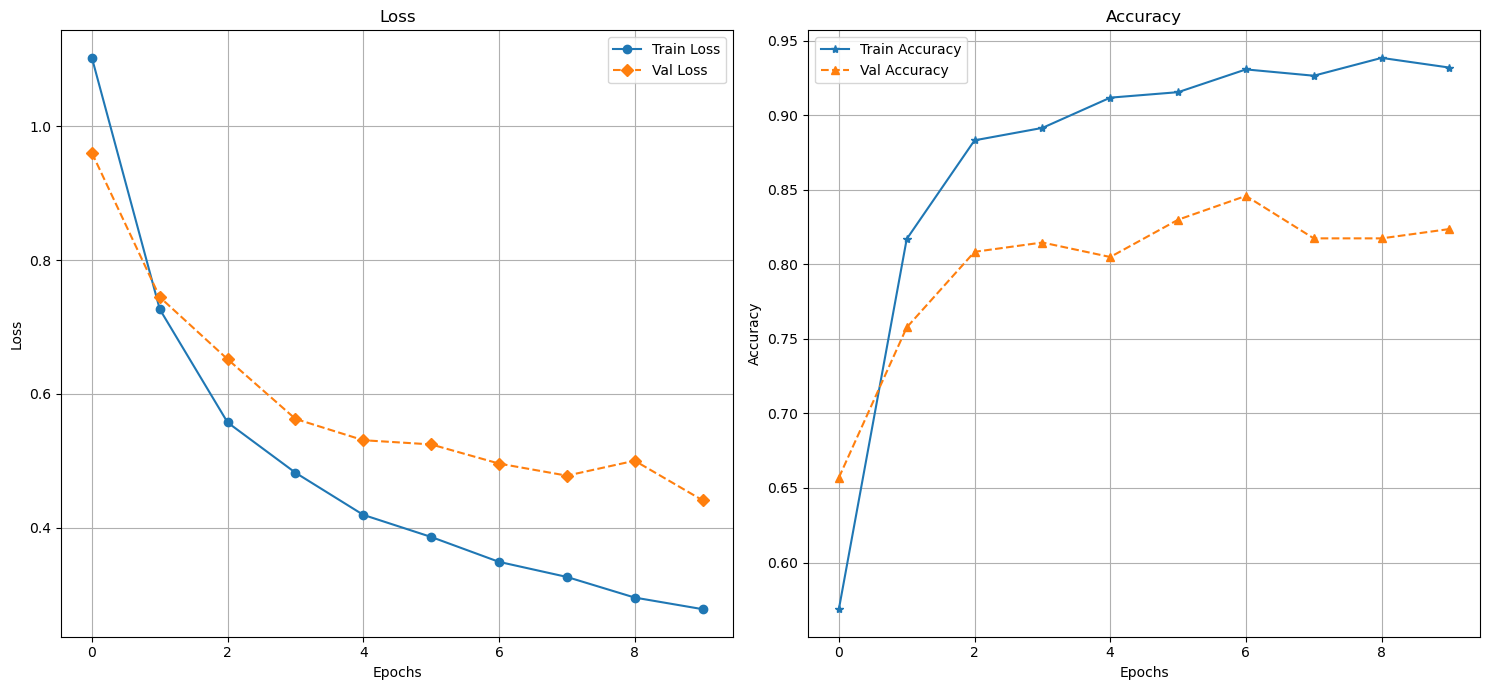

In [21]:
plot_loss_curves(results=results)

### plotting the confusion matrix

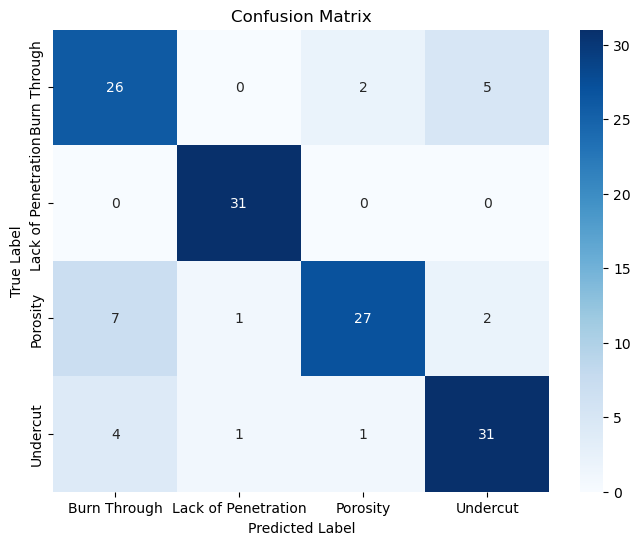

In [22]:
plot_confusion_matrix(model=res50_model,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

### 2.2 Fine tuning the ResNet50 model

In [23]:
from pathlib import Path
checkpoint_path = Path('C:/Users/Sadat Iqbal/Desktop/Python Works/Torch_CUDA/Publication_Phase_2_models/ResNet50_Original_data_10_epoch.pth')
checkpoint = torch.load(checkpoint_path,
                            map_location=device)

C:\Users\Sadat Iqbal\AppData\Local\Temp\ipykernel_12344\3552307727.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,


In [24]:
res50_finetune = torchvision.models.resnet50(weights=None).to(device)
res50_finetune.fc = nn.Linear(in_features=2048, out_features=num_classes).to(device)

res50_finetune.load_state_dict(checkpoint['model_state_dict'])

for child in list(res50_finetune.children())[:-2]:
    for param in child.parameters():
        param.requires_grad = False

summary(res50_finetune,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [25]:
feature_extractor = [(name, param) for name, param in res50_finetune.named_parameters()
if not name.startswith('fc') and not name.startswith('avgpool')]

for name, param in feature_extractor[-10:]:
    param.requires_grad = True

summary(res50_finetune,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### Training

In [26]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad,res50_finetune.parameters()),
    lr = 1e-4
)

fine_tune_epochs = 5

#starting th etimer
start_time = timer()
finetune_results = train(model = res50_finetune,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=criterion,
                        epochs=fine_tune_epochs,
                        device=device,
                        writer=create_writer(experiment_name='Original_Data',
                                            model_name = 'ResNet50',
                                            extra=f'finetunes_for_{fine_tune_epochs}_epochs')
                        )
end_time = timer()
print(f'Time taken for Fine-tuning: {end_time-start_time:.3f} seconds')

save_filepath = 'ResNet50_Original_data_finetuned_for_5_epochs.pth'
save_model(model=res50_finetune,
          optimizer=optimizer,
          epoch=n_epochs,
          initial_training_completed=True,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('Fine-tuned model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Original_Data\ResNet50\finetunes_for_5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.2510 and Train acuuracry: 0.9384 |
                  Validation loss: 0.4256 and Validation accuracy: 0.8236|
                  LR: 0.0001
Epoch: 2| Train loss: 0.1690 and Train acuuracry: 0.9688 |
                  Validation loss: 0.3881 and Validation accuracy: 0.8361|
                  LR: 0.0001
Epoch: 3| Train loss: 0.1180 and Train acuuracry: 0.9816 |
                  Validation loss: 0.4622 and Validation accuracy: 0.8174|
                  LR: 0.0001
Epoch: 4| Train loss: 0.0868 and Train acuuracry: 0.9870 |
                  Validation loss: 0.3767 and Validation accuracy: 0.8646|
                  LR: 0.0001
Epoch: 5| Train loss: 0.0577 and Train acuuracry: 0.9954 |
                  Validation loss: 0.4360 and Validation accuracy: 0.8486|
                  LR: 0.0001
Time taken for Fine-tuning: 259.225 seconds
[INFO] Saving checkpoint to: Publication_Phase_2_models\ResNet50_Original_data_finetuned_for_5_epochs.pth
Fine-tuned model saved to desired d

### Plotting loss curves

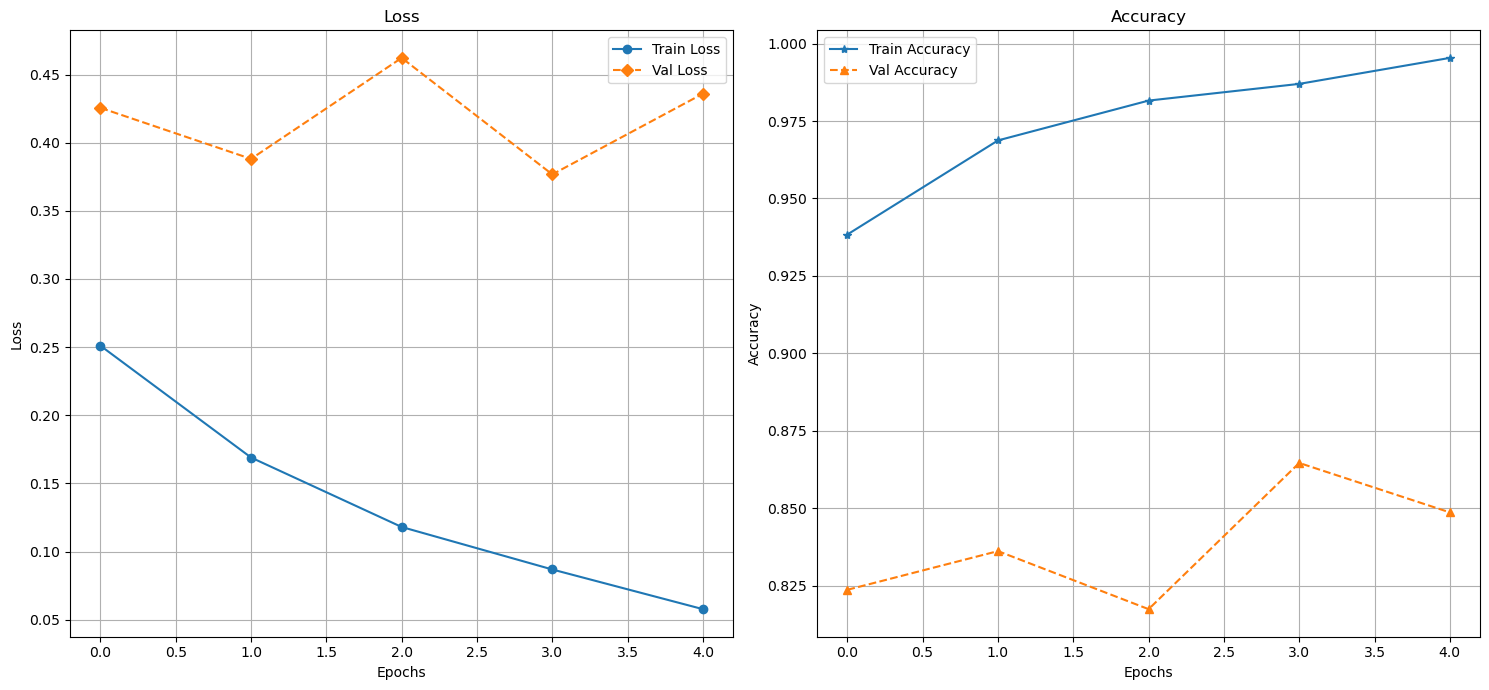

In [27]:
plot_loss_curves(results=finetune_results)

### Plotting confusion matrix

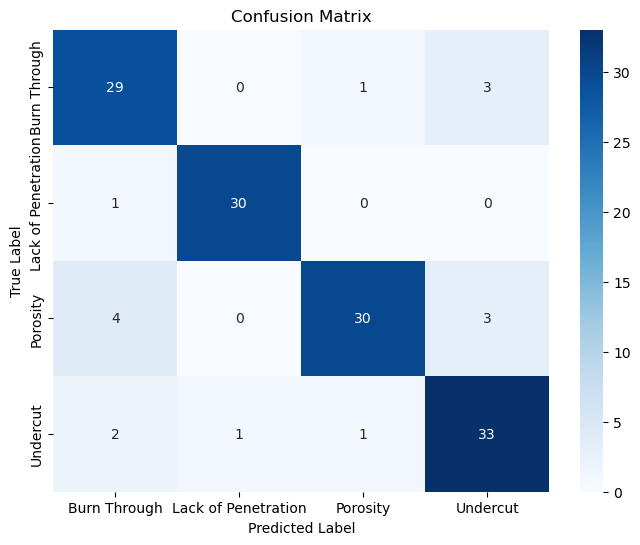

In [28]:
plot_confusion_matrix(model=res50_finetune,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)

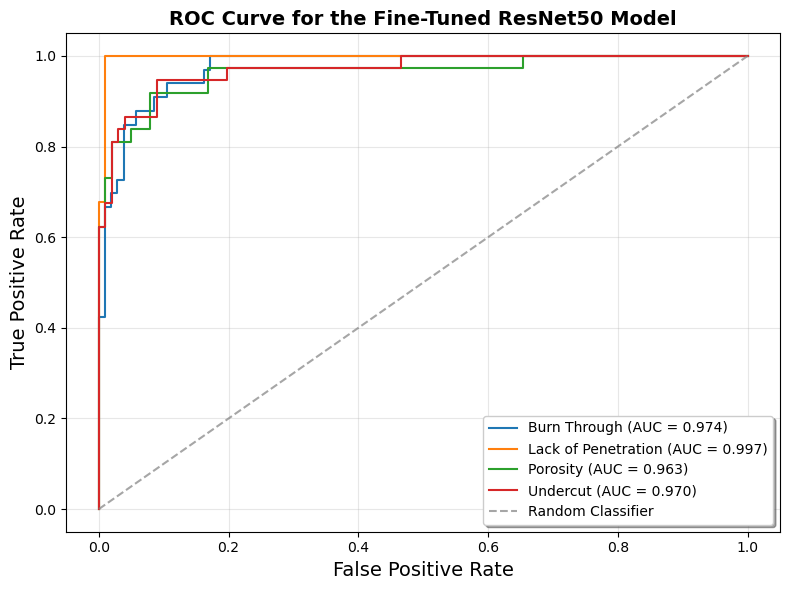

In [35]:
plot_multiclass_roc_curve(model = res50_finetune,
                         dataloader=test_dataloader,
                         class_names=class_names,
                         device=device,
                         title="ROC Curve for the Fine-Tuned ResNet50 Model")

# 3. Effect of SENet attention module

In [29]:
from AttentionModules.SENet import SEModule

class resnet50_with_senet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.weights = torchvision.models.ResNet50_Weights.DEFAULT
        self.model = torchvision.models.resnet50(weights=self.weights)
        self.feature_extractor = nn.Sequential(*list(self.model.children())[:-2])
        self.senet = SEModule(channels=2048)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=2048, out_features=num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.senet(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x

In [30]:
res50_se = resnet50_with_senet(num_classes=num_classes)
summary(res50_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
resnet50_with_senet (resnet50_with_senet)     [32, 3, 224, 224]    [32, 4]              2,049,000            True
├─Sequential (feature_extractor)              [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   True
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]   

In [31]:
for param in res50_se.feature_extractor.parameters():
    param.requires_grad = False

summary(res50_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
resnet50_with_senet (resnet50_with_senet)     [32, 3, 224, 224]    [32, 4]              2,049,000            Partial
├─Sequential (feature_extractor)              [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

### Training

In [32]:
#setting up random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#setting up a loss_fn and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res50_se.parameters(), lr = 1e-3)

n_epochs = 10

#starting the timer
start_time = timer()
results_se = train(model=res50_se,
                  train_dataloader=train_dataloader,
                  val_dataloader=val_dataloader,
                  optimizer=optimizer,
                  loss_fn=criterion,
                  epochs=n_epochs,
                  device=device,
                  writer=create_writer(experiment_name='Original_Data',
                                      model_name='ResNet50_with_SENet',
                                      extra=f'{n_epochs}_epochs')
                  )
end_time = timer()
print(f'Total training time with time: {end_time-start_time:.3f} seconds')

save_filepath = 'ResNet50_with_SENet_Original_data_10{epochs.pth'
save_model(model=res50_se,
          optimizer=optimizer,
          epoch=n_epochs,
          initial_training_completed=False,
          target_dir='Publication_Phase_2_models',
          model_name = save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Original_Data\ResNet50_with_SENet\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1| Train loss: 1.1148 and Train acuuracry: 0.5624 |
                  Validation loss: 0.9400 and Validation accuracy: 0.6562|
                  LR: 0.001
Epoch: 2| Train loss: 0.6824 and Train acuuracry: 0.8242 |
                  Validation loss: 0.6560 and Validation accuracy: 0.7639|
                  LR: 0.001
Epoch: 3| Train loss: 0.4785 and Train acuuracry: 0.8721 |
                  Validation loss: 0.5274 and Validation accuracy: 0.8271|
                  LR: 0.001
Epoch: 4| Train loss: 0.3582 and Train acuuracry: 0.9107 |
                  Validation loss: 0.5149 and Validation accuracy: 0.7924|
                  LR: 0.001
Epoch: 5| Train loss: 0.2676 and Train acuuracry: 0.9227 |
                  Validation loss: 0.4432 and Validation accuracy: 0.8174|
                  LR: 0.001
Epoch: 6| Train loss: 0.2152 and Train acuuracry: 0.9338 |
                  Validation loss: 0.4209 and Validation accuracy: 0.8299|
                  LR: 0.001
Epoch: 7| Train loss: 0.1694

### Plotting Loss Curves

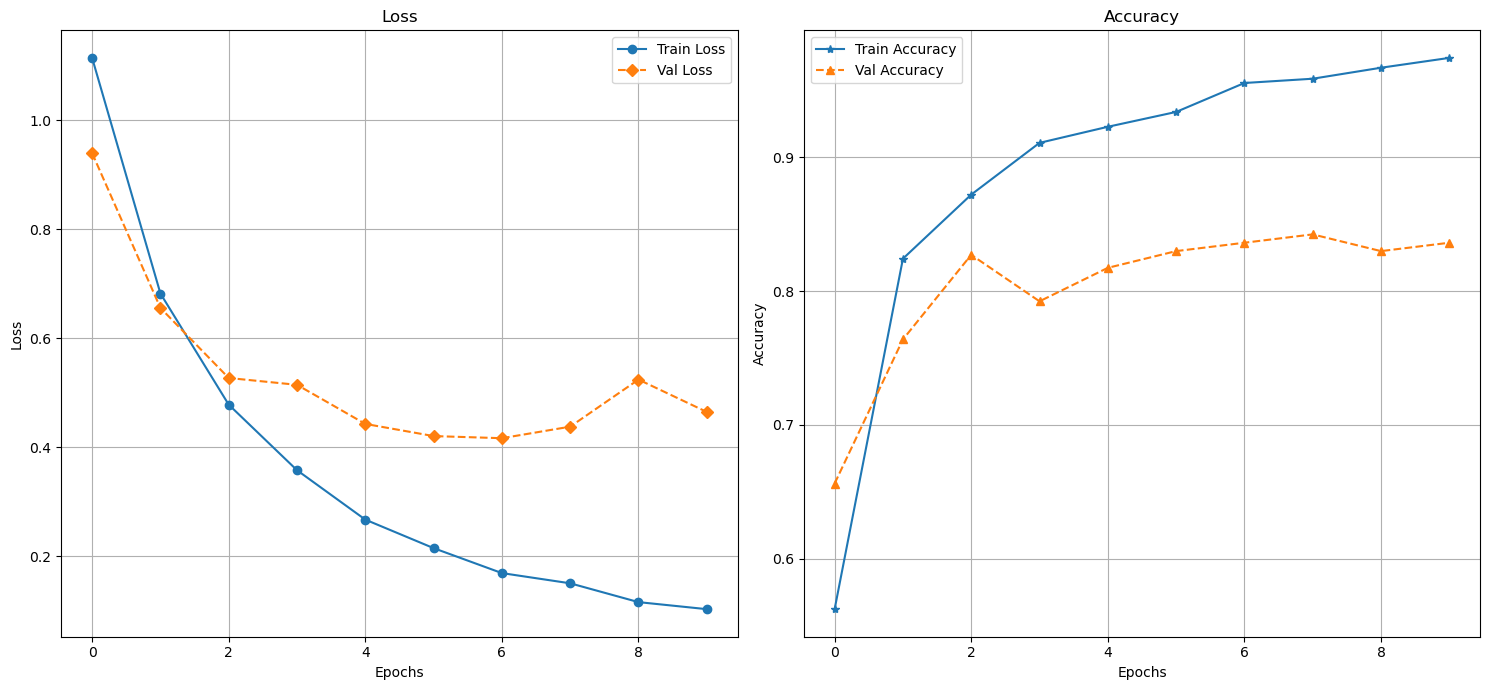

In [33]:
plot_loss_curves(results=results_se)

### Plotting confusion matrix

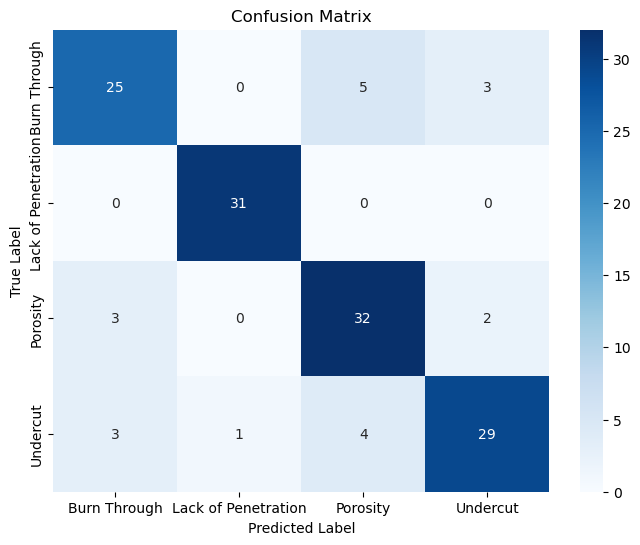

In [34]:
plot_confusion_matrix(model=res50_se,
                     dataloader=test_dataloader,
                     class_names=class_names,
                     device=device)